1. Imports & Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from entsoe import EntsoePandasClient
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# API-Key laden
load_dotenv()


True

2. Data fetch

In [9]:
def load_entsoe_prices(api_key, country_code="NL", start="20240101", end="20240131"):
    client = EntsoePandasClient(api_key=api_key)
    start = pd.Timestamp(start, tz="Europe/Amsterdam")
    end = pd.Timestamp(end, tz="Europe/Amsterdam")
    prices = client.query_day_ahead_prices(country_code, start=start, end=end)
    prices = prices.interpolate().bfill()
    return prices


3. Data sets with time features

In [3]:
class PriceDataset(Dataset):
    def __init__(self, series, index, input_len=168, forecast_len=24):
        self.X, self.Y, self.F = [], [], []

        hours = index.hour.to_numpy()
        hour_sin = np.sin(2 * np.pi * hours / 24)
        hour_cos = np.cos(2 * np.pi * hours / 24)
        hour_features = np.stack([hour_sin, hour_cos], axis=-1)

        for i in range(len(series) - input_len - forecast_len):
            self.X.append(series[i:i+input_len])
            self.Y.append(series[i+input_len:i+input_len+forecast_len])
            self.F.append(hour_features[i+input_len:i+input_len+forecast_len])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.Y = torch.tensor(np.array(self.Y), dtype=torch.float32)
        self.F = torch.tensor(np.array(self.F), dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.F[idx], self.Y[idx]


4. Latent GRU

In [4]:
class LatentGRU(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gru = nn.GRUCell(dim, dim)

    def forward(self, z):
        return self.gru(z, z)


5. DSSM Modell

In [5]:
class DSSM(nn.Module):
    def __init__(self, input_len=24, forecast_len=24, latent_dim=64, exog_dim=2):
        super().__init__()
        self.latent_dim = latent_dim
        self.forecast_len = forecast_len
        self.encoder = nn.GRU(1, latent_dim, batch_first=True)
        self.transition = LatentGRU(latent_dim)
        self.emission = nn.Sequential(
            nn.Linear(latent_dim + exog_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1)
        )

    def forward(self, x, f_exog):
        x = x.unsqueeze(-1)
        _, h = self.encoder(x)
        z = h[0]

        preds = []
        for t in range(self.forecast_len):
            z = self.transition(z)
            z_cat = torch.cat([z, f_exog[:, t, :]], dim=-1)
            y = self.emission(z_cat)
            preds.append(y.unsqueeze(1))
        return torch.cat(preds, dim=1).squeeze(-1)


6. Trainingsroutine

In [7]:
def train(model, dataloader, opt, loss_fn, epochs=100):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, f, y in dataloader:
            pred = model(x, f)
            loss = loss_fn(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(dataloader):.4f}")


7. Data prep & Training

In [13]:
api_key = os.getenv("ENTSOE_API_KEY")
assert api_key is not None, "Bitte ENTSOE_API_KEY setzen!"

prices = load_entsoe_prices(api_key, start="2024-01-01", end="2024-01-31")
price_series = prices.values.squeeze()
mean, std = price_series.mean(), price_series.std()
norm_series = (price_series - mean) / std

input_len = 24
forecast_len = 24
dataset = PriceDataset(norm_series, prices.index, input_len, forecast_len)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = DSSM(input_len, forecast_len, latent_dim=64, exog_dim=2)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.SmoothL1Loss()

train(model, dataloader, opt, loss_fn, epochs=1000)


Epoch 1: Loss = 0.3269
Epoch 2: Loss = 0.3011
Epoch 3: Loss = 0.2555
Epoch 4: Loss = 0.2310
Epoch 5: Loss = 0.2203
Epoch 6: Loss = 0.2134
Epoch 7: Loss = 0.2116
Epoch 8: Loss = 0.2097
Epoch 9: Loss = 0.2030
Epoch 10: Loss = 0.1999
Epoch 11: Loss = 0.2017
Epoch 12: Loss = 0.2010
Epoch 13: Loss = 0.1949
Epoch 14: Loss = 0.1929
Epoch 15: Loss = 0.1886
Epoch 16: Loss = 0.1869
Epoch 17: Loss = 0.1829
Epoch 18: Loss = 0.1786
Epoch 19: Loss = 0.1770
Epoch 20: Loss = 0.1714
Epoch 21: Loss = 0.1680
Epoch 22: Loss = 0.1676
Epoch 23: Loss = 0.1637
Epoch 24: Loss = 0.1613
Epoch 25: Loss = 0.1603
Epoch 26: Loss = 0.1600
Epoch 27: Loss = 0.1539
Epoch 28: Loss = 0.1503
Epoch 29: Loss = 0.1476
Epoch 30: Loss = 0.1448
Epoch 31: Loss = 0.1420
Epoch 32: Loss = 0.1448
Epoch 33: Loss = 0.1398
Epoch 34: Loss = 0.1360
Epoch 35: Loss = 0.1347
Epoch 36: Loss = 0.1301
Epoch 37: Loss = 0.1273
Epoch 38: Loss = 0.1247
Epoch 39: Loss = 0.1291
Epoch 40: Loss = 0.1240
Epoch 41: Loss = 0.1216
Epoch 42: Loss = 0.1188
E

8. Forecast & Visulization

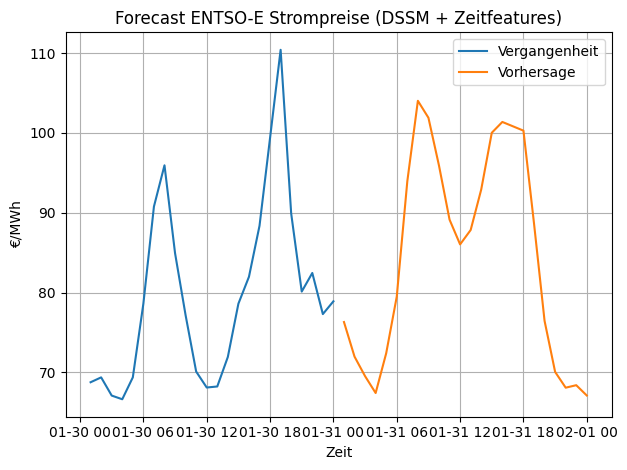

In [15]:
model.eval()
with torch.no_grad():
    x = torch.tensor(norm_series[-input_len:], dtype=torch.float32).unsqueeze(0)

    h_last = prices.index[-forecast_len:]
    h_sin = np.sin(2 * np.pi * h_last.hour / 24)
    h_cos = np.cos(2 * np.pi * h_last.hour / 24)
    f_exog = torch.tensor(np.stack([h_sin, h_cos], axis=-1), dtype=torch.float32).unsqueeze(0)

    pred = model(x, f_exog).numpy().flatten()
    pred_rescaled = pred * std + mean

plt.plot(prices.index[-input_len:], x.squeeze().numpy() * std + mean, label="Vergangenheit")
forecast_index = [prices.index[-1] + timedelta(hours=i+1) for i in range(forecast_len)]
plt.plot(forecast_index, pred_rescaled, label="Vorhersage")
plt.title("Forecast ENTSO-E Strompreise (DSSM + Zeitfeatures)")
plt.xlabel("Zeit")
plt.ylabel("€/MWh")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


9. month & weekplots

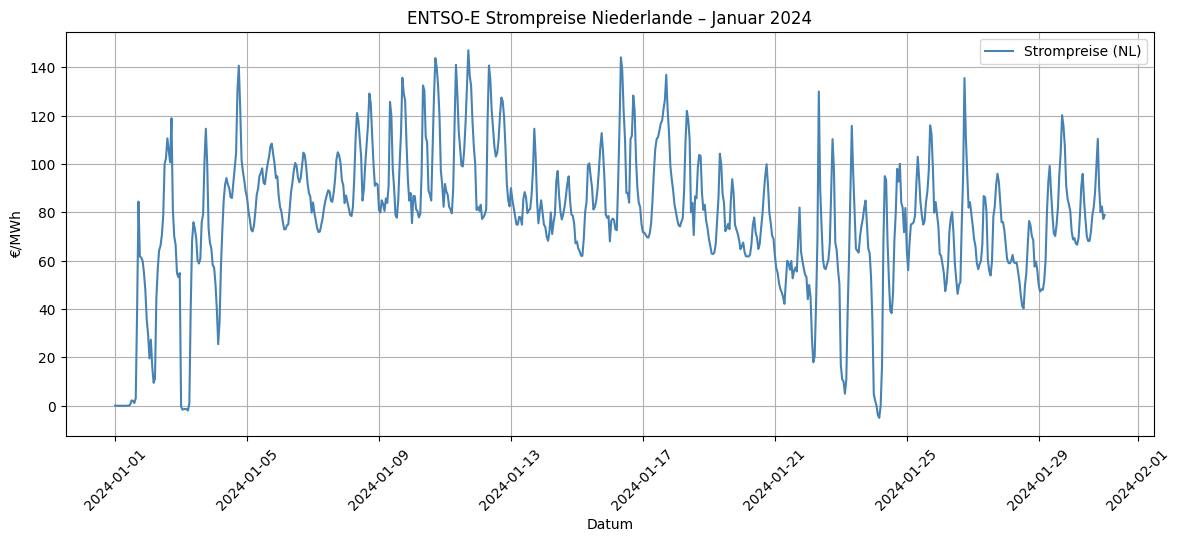

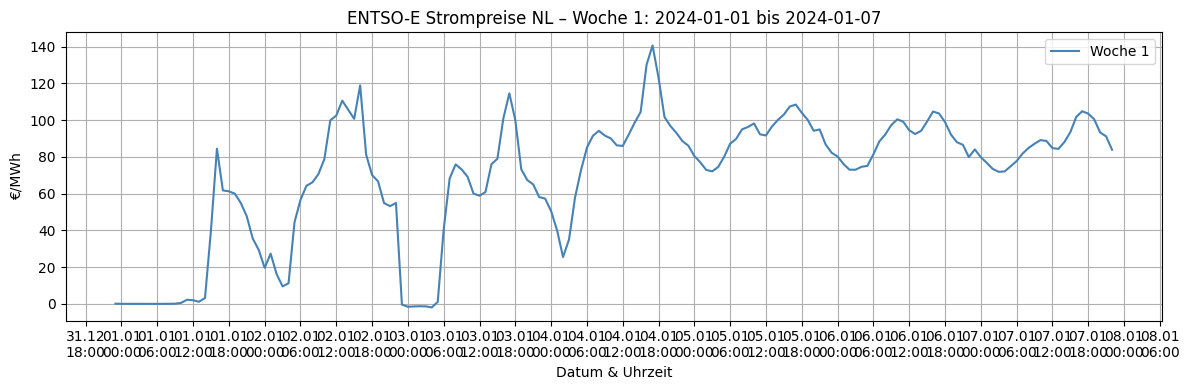

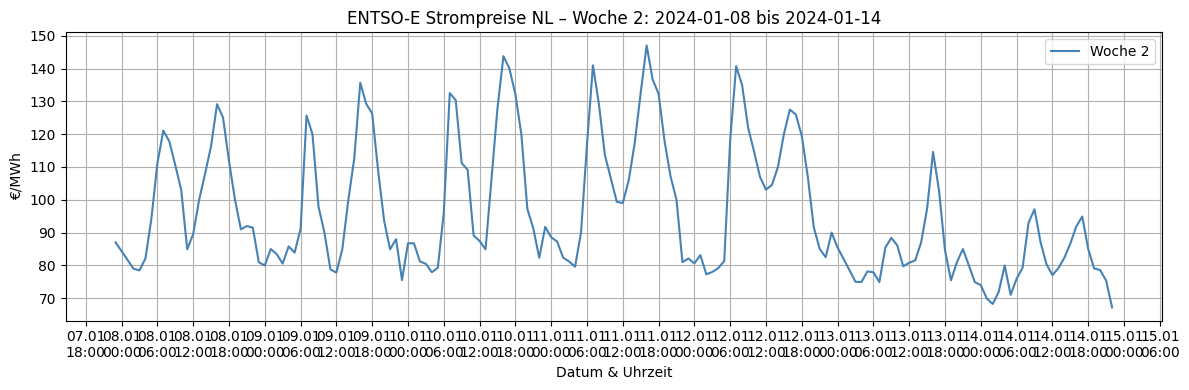

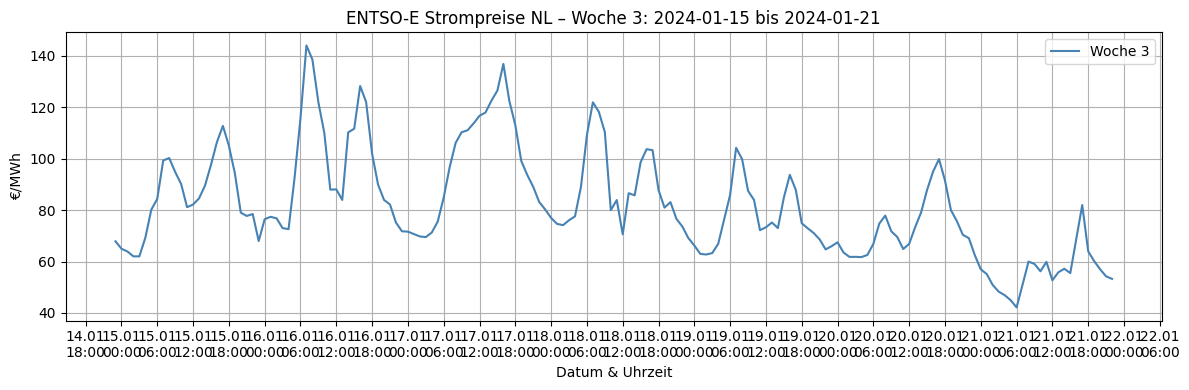

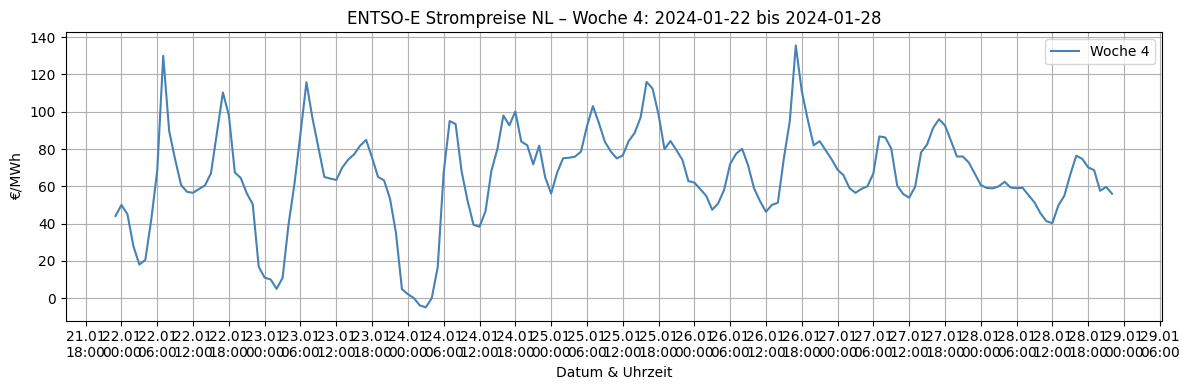

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(prices.index, prices.values, label="Strompreise (NL)", color="steelblue")
plt.title("ENTSO-E Strompreise Niederlande – Januar 2024")
plt.xlabel("Datum")
plt.ylabel("€/MWh")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

import matplotlib.dates as mdates

weeks = [("2024-01-01", "2024-01-07"),
         ("2024-01-08", "2024-01-14"),
         ("2024-01-15", "2024-01-21"),
         ("2024-01-22", "2024-01-28")]

for i, (start, end) in enumerate(weeks, 1):
    week_data = prices[start:end]
    plt.figure(figsize=(12, 4))
    plt.plot(week_data.index, week_data.values, label=f"Woche {i}", color="steelblue")
    plt.title(f"ENTSO-E Strompreise NL – Woche {i}: {start} bis {end}")
    plt.xlabel("Datum & Uhrzeit")
    plt.ylabel("€/MWh")
    plt.grid(True)
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m\n%H:%M'))
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.show()
